# Obtención de insights a partir de visualizaciones

[Link a github](https://github.com/sabrinacabrera922/MAL_Anime_EDA_y_ML)

# 1. Abstracto

**Motivación**

El anime ha pasado de ser un nicho cultural en Japón a convertirse en un fenómeno global que influye en el entretenimiento, la moda y el arte de todo el mundo. Mediante el análisis de los datos recogidos en MyAnimeList, busco comprender las tendencias, preferencias y comportamientos de los usuarios del anime. Este análisis no sólo permitirá descubrir qué series son más populares entre los aficionados, sino también identificar patrones demográficos y temporales (entre otros) que podrían ayudar en recomendaciones para personas en búsqueda de nuevos títulos.

El **objetivo principal** es generar un algoritmo de recomendación de anime, en base a los datos obtenidos de MyAnimeList.


Otros **objetivos secundarios** son realizar un análisis acerca del  fenómeno del anime, explorar datos a través de los años, los títulos más populares, demográfica, etc.


**Audiencia**

Los fans del anime, que podrán descubrir títulos que podrían desconocer y obtener una comprensión más profunda de cómo sus propias preferencias se alinean o difieren de las tendencias generales.


**Preguntas/hipótesis**

* ¿Incide la demográfica en la elección de los animes?

* ¿Suele un género realmente mirar el anime demográficamente denominado como tal?

* ¿Pasa similar a ésto con la demográfica de edades?


# 2. Importación de librerias

In [198]:
# Instalación de JikanPy -- es un contenedor de Python para Jikan, que proporciona enlaces para todas las funciones de API y es compatible con Python 3.6+
!pip install git+https://github.com/abhinavk99/jikanpy.git
!pip install wordcloud matplotlib requests
!pip install aiohttp
!pip install matplotlib seaborn
#!pip install pandas-profiling==3.6.2

#Imports
import requests # HTTP library
import pandas as pd
import numpy as np
import networkx as nx # crear y manipular gráficos y redes
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import time  # Para hacer pausas entre solicitudes
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
from IPython.display import display, HTML
import seaborn as sns
import datetime
from bs4 import BeautifulSoup
import json
import re
from scipy.stats import ttest_ind
from google.colab import files
#from pandas_profiling import ProfileReport

  Cloning https://github.com/abhinavk99/jikanpy.git to /tmp/pip-req-build-dejm3t2f
  Running command git clone --filter=blob:none --quiet https://github.com/abhinavk99/jikanpy.git /tmp/pip-req-build-dejm3t2f
  Resolved https://github.com/abhinavk99/jikanpy.git to commit 0c255d2c718a5822f434285797b2641bfeea6cca
  Preparing metadata (setup.py) ... done


# 3. Importación de datos

**Montaje del Drive**

In [199]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importación de datos desde bases de datos**

In [200]:
anime_cleaned_df = pd.read_csv('/content/drive/MyDrive/my_anime_list_23/anime_cleaned.csv', low_memory=False)

In [201]:
UserAnimeList = pd.read_csv('/content/drive/MyDrive/my_anime_list_23/UserAnimeList_muestra.csv', low_memory=False)

In [202]:
user_df = pd.read_csv('/content/drive/MyDrive/my_anime_list_23/users.csv', low_memory=False)

**Importación de datos desde la API [Jikan](https://docs.api.jikan.moe/)**

In [203]:
# Defino la URL de la API de Jikan para la versión 4
url = "https://api.jikan.moe/v4/anime/1"

# Realizo una solicitud GET a la API
response = requests.get(url)

# Verifico si la solicitud fue exitosa
if response.status_code == 200:
    anime_data = response.json()

    if isinstance(anime_data, dict):
        # Creo un df a partir de los datos obtenidos
        df = pd.DataFrame.from_dict(anime_data, orient='index').transpose()

        # Muestro el df
        print(df)
    else:
        print("los datos recibidos no son un diccionario")
else:
    print(f"Ocurrió un error: {response.status_code}. {response.text}")

    time.sleep(2)  # pausa de 2 segundos

                                                              data
mal_id                                                           1
url                   https://myanimelist.net/anime/1/Cowboy_Bebop
images           {'jpg': {'image_url': 'https://cdn.myanimelist...
trailer          {'youtube_id': 'gY5nDXOtv_o', 'url': 'https://...
approved                                                      True
titles           [{'type': 'Default', 'title': 'Cowboy Bebop'},...
title                                                 Cowboy Bebop
title_english                                         Cowboy Bebop
title_japanese                                           カウボーイビバップ
title_synonyms                                                  []
type                                                            TV
source                                                    Original
episodes                                                        26
status                                             Finished Ai

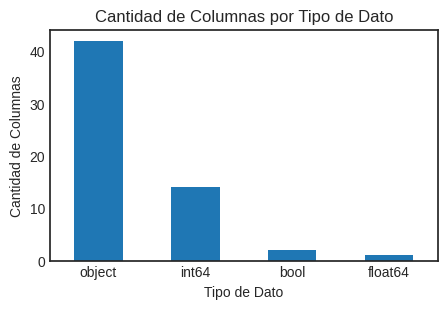

In [204]:
if response.status_code == 200:
    anime_data = response.json()['data']

    # Creo un df a partir de los datos obtenidos
    df = pd.json_normalize(anime_data)

    # Cuento el número de columnas para cada tipo de dato
    dtype_counts = df.dtypes.value_counts()

    # Creo un gráfico de barras con esta información
    plt.figure(figsize=(5, 3))
    dtype_counts.plot(kind='bar')
    plt.title('Cantidad de Columnas por Tipo de Dato')
    plt.xlabel('Tipo de Dato')
    plt.ylabel('Cantidad de Columnas')
    plt.xticks(rotation='horizontal')
    plt.show()
else:
    print(f"Error al realizar la solicitud: {response.status_code}")


In [205]:
print(df.head())


   mal_id                                           url  approved  \
0       1  https://myanimelist.net/anime/1/Cowboy_Bebop      True   

                                              titles         title  \
0  [{'type': 'Default', 'title': 'Cowboy Bebop'},...  Cowboy Bebop   

  title_english title_japanese title_synonyms type    source  ...  \
0  Cowboy Bebop      カウボーイビバップ             []   TV  Original  ...   

   aired.prop.from.month aired.prop.from.year  aired.prop.to.day  \
0                      4                 1998                 24   

  aired.prop.to.month aired.prop.to.year                 aired.string  \
0                   4               1999  Apr 3, 1998 to Apr 24, 1999   

   broadcast.day  broadcast.time  broadcast.timezone          broadcast.string  
0      Saturdays           01:00          Asia/Tokyo  Saturdays at 01:00 (JST)  

[1 rows x 59 columns]


In [206]:
print(df.columns)


Index(['mal_id', 'url', 'approved', 'titles', 'title', 'title_english',
       'title_japanese', 'title_synonyms', 'type', 'source', 'episodes',
       'status', 'airing', 'duration', 'rating', 'score', 'scored_by', 'rank',
       'popularity', 'members', 'favorites', 'synopsis', 'background',
       'season', 'year', 'producers', 'licensors', 'studios', 'genres',
       'explicit_genres', 'themes', 'demographics', 'images.jpg.image_url',
       'images.jpg.small_image_url', 'images.jpg.large_image_url',
       'images.webp.image_url', 'images.webp.small_image_url',
       'images.webp.large_image_url', 'trailer.youtube_id', 'trailer.url',
       'trailer.embed_url', 'trailer.images.image_url',
       'trailer.images.small_image_url', 'trailer.images.medium_image_url',
       'trailer.images.large_image_url', 'trailer.images.maximum_image_url',
       'aired.from', 'aired.to', 'aired.prop.from.day',
       'aired.prop.from.month', 'aired.prop.from.year', 'aired.prop.to.day',
       'ai

In [207]:
# reemplazo 'data.' con una cadena vacía (''), eliminando 'data.' de los nombres de las columnas en el df
df.columns = df.columns.str.replace('data.', '', regex=False)

# imprimo las columnas 'title', 'episodes', y 'score' del df para visualizar esos datos
print(df[['title', 'episodes', 'score']])

          title  episodes  score
0  Cowboy Bebop        26   8.75


# 4. Exploración de datos

In [208]:
# Defino la URL de la API de Jikan para la versión 4
url = "https://api.jikan.moe/v4/anime/1"

# Realizo una solicitud GET a la API
response = requests.get(url)

# Verifico si la solicitud fue exitosa
if response.status_code == 200:
    anime_data = response.json()

    if isinstance(anime_data, dict):
        # Creo un df a partir de los datos obtenidos
        df = pd.DataFrame.from_dict(anime_data, orient='index').transpose()

        # Muestro el df
        print(df)
    else:
        print("los datos recibidos no son un diccionario")
else:
    print(f"Ocurrió un error: {response.status_code}. {response.text}")

    time.sleep(2)  # pausa de 2 segundos

                                                              data
mal_id                                                           1
url                   https://myanimelist.net/anime/1/Cowboy_Bebop
images           {'jpg': {'image_url': 'https://cdn.myanimelist...
trailer          {'youtube_id': 'gY5nDXOtv_o', 'url': 'https://...
approved                                                      True
titles           [{'type': 'Default', 'title': 'Cowboy Bebop'},...
title                                                 Cowboy Bebop
title_english                                         Cowboy Bebop
title_japanese                                           カウボーイビバップ
title_synonyms                                                  []
type                                                            TV
source                                                    Original
episodes                                                        26
status                                             Finished Ai

In [209]:
print(df.head())


                                                       data
mal_id                                                    1
url            https://myanimelist.net/anime/1/Cowboy_Bebop
images    {'jpg': {'image_url': 'https://cdn.myanimelist...
trailer   {'youtube_id': 'gY5nDXOtv_o', 'url': 'https://...
approved                                               True


In [210]:
print(df.columns)


Index(['data'], dtype='object')


In [211]:
if anime_data:
    # Construyo df directamente desde JSON
    df = pd.json_normalize(anime_data)

    # Muestro información del df
    print(df.info())

    # Muestro un resumen estadístico del df
    print(df.describe())

    # Selecciono y muestro columnas específicas
    print(df[['data.title', 'data.episodes', 'data.score']])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 59 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   data.mal_id                            1 non-null      int64  
 1   data.url                               1 non-null      object 
 2   data.images.jpg.image_url              1 non-null      object 
 3   data.images.jpg.small_image_url        1 non-null      object 
 4   data.images.jpg.large_image_url        1 non-null      object 
 5   data.images.webp.image_url             1 non-null      object 
 6   data.images.webp.small_image_url       1 non-null      object 
 7   data.images.webp.large_image_url       1 non-null      object 
 8   data.trailer.youtube_id                1 non-null      object 
 9   data.trailer.url                       1 non-null      object 
 10  data.trailer.embed_url                 1 non-null      object 
 11  data.trail

In [212]:
# reemplazo 'data.' con una cadena vacía (''), eliminando 'data.' de los nombres de las columnas en el df
df.columns = df.columns.str.replace('data.', '', regex=False)

# imprimo las columnas 'title', 'episodes', y 'score' del df para visualizar esos datos
print(df[['title', 'episodes', 'score']])

          title  episodes  score
0  Cowboy Bebop        26   8.75


# 5. Data Wrangling

**Inspección inicial**

In [213]:
df.head()

,mal_id,url,images.jpg.image_url,images.jpg.small_image_url,images.jpg.large_image_url,images.webp.image_url,images.webp.small_image_url,images.webp.large_image_url,trailer.youtube_id,trailer.url,...,broadcast.time,broadcast.timezone,broadcast.string,producers,licensors,studios,genres,explicit_genres,themes,demographics
0,1,https://myanimelist.net/anime/1/Cowboy_Bebop,https://cdn.myanimelist.net/images/anime/4/196...,https://cdn.myanimelist.net/images/anime/4/196...,https://cdn.myanimelist.net/images/anime/4/196...,https://cdn.myanimelist.net/images/anime/4/196...,https://cdn.myanimelist.net/images/anime/4/196...,https://cdn.myanimelist.net/images/anime/4/196...,gY5nDXOtv_o,https://www.youtube.com/watch?v=gY5nDXOtv_o,...,01:00,Asia/Tokyo,Saturdays at 01:00 (JST),"[{'mal_id': 23, 'type': 'anime', 'name': 'Band...","[{'mal_id': 102, 'type': 'anime', 'name': 'Fun...","[{'mal_id': 14, 'type': 'anime', 'name': 'Sunr...","[{'mal_id': 1, 'type': 'anime', 'name': 'Actio...",[],"[{'mal_id': 50, 'type': 'anime', 'name': 'Adul...",[]


In [214]:
df.tail()

,mal_id,url,images.jpg.image_url,images.jpg.small_image_url,images.jpg.large_image_url,images.webp.image_url,images.webp.small_image_url,images.webp.large_image_url,trailer.youtube_id,trailer.url,...,broadcast.time,broadcast.timezone,broadcast.string,producers,licensors,studios,genres,explicit_genres,themes,demographics
0,1,https://myanimelist.net/anime/1/Cowboy_Bebop,https://cdn.myanimelist.net/images/anime/4/196...,https://cdn.myanimelist.net/images/anime/4/196...,https://cdn.myanimelist.net/images/anime/4/196...,https://cdn.myanimelist.net/images/anime/4/196...,https://cdn.myanimelist.net/images/anime/4/196...,https://cdn.myanimelist.net/images/anime/4/196...,gY5nDXOtv_o,https://www.youtube.com/watch?v=gY5nDXOtv_o,...,01:00,Asia/Tokyo,Saturdays at 01:00 (JST),"[{'mal_id': 23, 'type': 'anime', 'name': 'Band...","[{'mal_id': 102, 'type': 'anime', 'name': 'Fun...","[{'mal_id': 14, 'type': 'anime', 'name': 'Sunr...","[{'mal_id': 1, 'type': 'anime', 'name': 'Actio...",[],"[{'mal_id': 50, 'type': 'anime', 'name': 'Adul...",[]


In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 59 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   mal_id                            1 non-null      int64  
 1   url                               1 non-null      object 
 2   images.jpg.image_url              1 non-null      object 
 3   images.jpg.small_image_url        1 non-null      object 
 4   images.jpg.large_image_url        1 non-null      object 
 5   images.webp.image_url             1 non-null      object 
 6   images.webp.small_image_url       1 non-null      object 
 7   images.webp.large_image_url       1 non-null      object 
 8   trailer.youtube_id                1 non-null      object 
 9   trailer.url                       1 non-null      object 
 10  trailer.embed_url                 1 non-null      object 
 11  trailer.images.image_url          1 non-null      object 
 12  trailer.imag

In [216]:
df.describe()

,mal_id,episodes,aired.prop.from.day,aired.prop.from.month,aired.prop.from.year,aired.prop.to.day,aired.prop.to.month,aired.prop.to.year,score,scored_by,rank,popularity,members,favorites,year
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0
mean,1.0,26.0,3.0,4.0,1998.0,24.0,4.0,1999.0,8.75,936783.0,46.0,43.0,1813631.0,80397.0,1998.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.0,26.0,3.0,4.0,1998.0,24.0,4.0,1999.0,8.75,936783.0,46.0,43.0,1813631.0,80397.0,1998.0
25%,1.0,26.0,3.0,4.0,1998.0,24.0,4.0,1999.0,8.75,936783.0,46.0,43.0,1813631.0,80397.0,1998.0
50%,1.0,26.0,3.0,4.0,1998.0,24.0,4.0,1999.0,8.75,936783.0,46.0,43.0,1813631.0,80397.0,1998.0
75%,1.0,26.0,3.0,4.0,1998.0,24.0,4.0,1999.0,8.75,936783.0,46.0,43.0,1813631.0,80397.0,1998.0
max,1.0,26.0,3.0,4.0,1998.0,24.0,4.0,1999.0,8.75,936783.0,46.0,43.0,1813631.0,80397.0,1998.0


**Manejo de Valores Faltantes**

In [217]:
df.isnull().sum()

mal_id                              0
url                                 0
images.jpg.image_url                0
images.jpg.small_image_url          0
images.jpg.large_image_url          0
images.webp.image_url               0
images.webp.small_image_url         0
images.webp.large_image_url         0
trailer.youtube_id                  0
trailer.url                         0
trailer.embed_url                   0
trailer.images.image_url            0
trailer.images.small_image_url      0
trailer.images.medium_image_url     0
trailer.images.large_image_url      0
trailer.images.maximum_image_url    0
approved                            0
titles                              0
title                               0
title_english                       0
title_japanese                      0
title_synonyms                      0
type                                0
source                              0
episodes                            0
status                              0
airing      

**Transformación de Datos**

In [218]:
def is_valid_url(url):
    """ Función para verificar si una URL es válida."""
    try:
        response = requests.get(url, timeout=3)
        return response.status_code == 200
    except requests.RequestException:
        return False

Operaciones sobre df_clean

In [219]:
# Hago una copia del df original para no alterar los datos originales
df_clean = df.copy()

In [220]:
# Convierto las fechas 'aired.from' y 'aired.to' a formato datetime
df_clean['aired.from'] = pd.to_datetime(df_clean['aired.from'])
df_clean['aired.to'] = pd.to_datetime(df_clean['aired.to'])

In [221]:
# Si existen las columnas adicionales de fechas, las combino y convierto
if 'aired.prop.from.year' in df_clean.columns:
    df_clean['aired_from_combined'] = pd.to_datetime(df_clean['aired.prop.from.year']*10000 + df_clean['aired.prop.from.month']*100 + df_clean['aired.prop.from.day'], format='%Y%m%d')
    df_clean['aired_to_combined'] = pd.to_datetime(df_clean['aired.prop.to.year']*10000 + df_clean['aired.prop.to.month']*100 + df_clean['aired.prop.to.day'], format='%Y%m%d')
else:
    print("Falta información: las columnas de fecha 'aired.prop.from' y 'aired.prop.to' no están presentes. Hay que revisar el df")


Operaciones sobre df

In [222]:
# Transformo la columna 'title_synonyms' en una cadena delimitada por comas
df['title_synonyms'] = df['title_synonyms'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

In [223]:
# Extraigo el título principal de la columna 'titles' y luego la elimino
df['main_title'] = df['titles'].apply(lambda x: next((item['title'] for item in x if item['type'] == 'Default'), None))
df.drop('titles', axis=1, inplace=True)

In [224]:
# Añado una nueva columna que me indica si la URL del tráiler es válida
df['trailer_url_valid'] = df['trailer.url'].apply(is_valid_url)

In [225]:
# Compruebo si tengo valores faltantes en el DataFrame
missing_values = df.isnull().sum()
if any(missing_values > 0):
    print(missing_values[missing_values > 0])  # Imprimo las columnas que tienen valores faltantes y cuántos son

In [226]:
# Imprimo las primeras filas de df_clean para verificar los cambios realizados
print(df_clean.head())

   mal_id                                           url  \
0       1  https://myanimelist.net/anime/1/Cowboy_Bebop   

                                images.jpg.image_url  \
0  https://cdn.myanimelist.net/images/anime/4/196...   

                          images.jpg.small_image_url  \
0  https://cdn.myanimelist.net/images/anime/4/196...   

                          images.jpg.large_image_url  \
0  https://cdn.myanimelist.net/images/anime/4/196...   

                               images.webp.image_url  \
0  https://cdn.myanimelist.net/images/anime/4/196...   

                         images.webp.small_image_url  \
0  https://cdn.myanimelist.net/images/anime/4/196...   

                         images.webp.large_image_url trailer.youtube_id  \
0  https://cdn.myanimelist.net/images/anime/4/196...        gY5nDXOtv_o   

                                   trailer.url  ...          broadcast.string  \
0  https://www.youtube.com/watch?v=gY5nDXOtv_o  ...  Saturdays at 01:00 (JST)   

  

In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 60 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   mal_id                            1 non-null      int64  
 1   url                               1 non-null      object 
 2   images.jpg.image_url              1 non-null      object 
 3   images.jpg.small_image_url        1 non-null      object 
 4   images.jpg.large_image_url        1 non-null      object 
 5   images.webp.image_url             1 non-null      object 
 6   images.webp.small_image_url       1 non-null      object 
 7   images.webp.large_image_url       1 non-null      object 
 8   trailer.youtube_id                1 non-null      object 
 9   trailer.url                       1 non-null      object 
 10  trailer.embed_url                 1 non-null      object 
 11  trailer.images.image_url          1 non-null      object 
 12  trailer.imag

# 6. Insights Generales

<ipython-input-228-a03f665bbdd0>:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



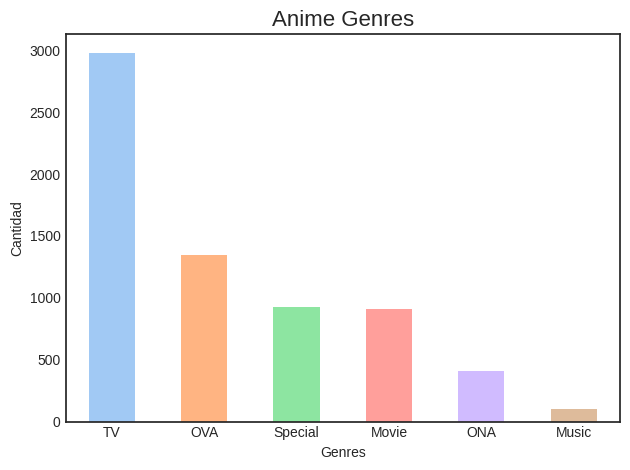

In [228]:
plt.style.use('seaborn-white')
pastel_palette = sns.color_palette("pastel")
anime_cleaned_df['type'].value_counts().plot(kind='bar', color=pastel_palette)

plt.title("Anime Genres", fontsize=16)
plt.xlabel("Genres", fontsize=10)
plt.ylabel("Cantidad", fontsize=10)

plt.xticks(rotation='horizontal')

plt.tight_layout()
plt.show()

La mayoría de los titulos son producciones para TV, el resto son OVA ('Original video animation', producciones generalmente especiales de pocos o un solo episodio), luego especiales y peliculas, casi la misma cantidad. ONA ('Original net animation', producciones directamente creadas para internet) y en mucho menor medida animes musicales.

Veamos la popularidad de los top 10 animes de todos los tiempos, con mayor cantidad de episodios:

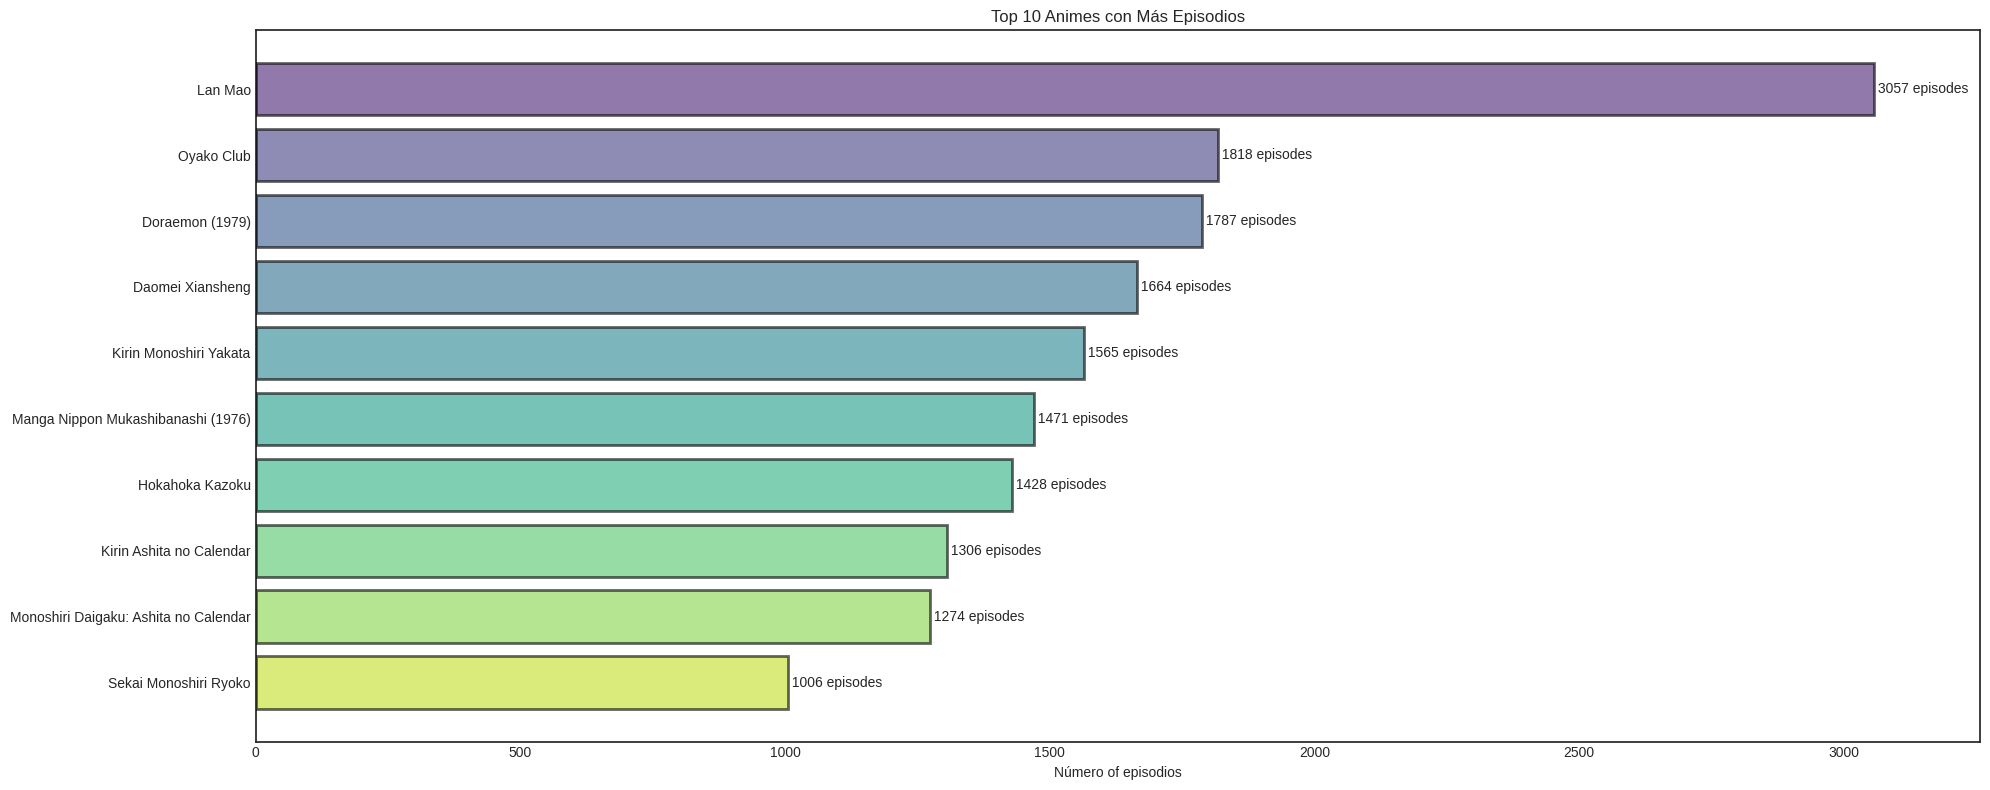

In [229]:
def get_top_animes_with_most_episodes(page=1):
    url = f"https://api.jikan.moe/v4/anime?order_by=episodes&sort=desc&page={page}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        return data.get("data")
    else:
        return []

def get_anime_popularity(anime_id):
    time.sleep(2)  # retraso para respetar la API
    url = f"https://api.jikan.moe/v4/anime/{anime_id}/statistics"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        return data.get("data", {}).get("statistics", {}).get("popularity")
    else:
        return None

def main():
    top_animes = get_top_animes_with_most_episodes()

    # Creo un df para los datos
    df = pd.DataFrame({
        'Title': [anime['title'] for anime in top_animes],
        'Episodes': [anime['episodes'] for anime in top_animes],
        'Popularity': [get_anime_popularity(anime['mal_id']) for anime in top_animes],
        'Favorites': [anime['favorites'] for anime in top_animes],
    }).head(10)

    # Visualización con un gráfico de barras
    plt.figure(figsize=(20, 8))
    bars = plt.barh(df['Title'], df['Episodes'], color=sns.color_palette("viridis", len(df)))

    # Añado la popularidad como tamaño de las barras
    for bar, popularity in zip(bars, df['Popularity']):
        bar.set_alpha(0.6)
        bar.set_linewidth(2)
        bar.set_edgecolor('black')
        bar.set_zorder(3)
        bar.set_label(f'Popularity: {popularity}')

    # Añado etiquetas con la cantidad de episodios
    for i, (episodes, title) in enumerate(zip(df['Episodes'], df['Title'])):
        plt.text(episodes, i, f' {episodes} episodes', va='center')

    # ajusto el límite del eje x y margen derecho
    max_episodes = df['Episodes'].max()
    plt.xlim(0, max_episodes + 200)  # buffer adicional para el texto
    plt.subplots_adjust(right=1)  # ajuste de margen derecho para acomodar el texto


    plt.xlabel('Número of episodios')
    plt.title('Top 10 Animes con Más Episodios')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


No hay una relación aparente entre la cantidad de episodios, al menos positiva, y los favoritos (popularidad) de los animes. El unico a Destacar es Doraemon, un anime muy popular, orientado a niños.

¿Cómo ha sido la evolución de lanzamientos de titulos a través de las décadas?

In [230]:
fig = px.histogram(anime_cleaned_df, x="aired_from_year", color="type", nbins=10)

fig.update_traces(marker=dict(line=dict(color='rgba(255,255,255,1)', width=3)))

fig.update_layout(
    plot_bgcolor='rgba(255,255,255,1)',
    paper_bgcolor='rgba(255,255,255,1)',
    font_family="Arial, sans-serif",
    font_color="black",
    title='Lanzamientos de anime por año',
    xaxis_title='Año lanzamiento',
    yaxis_title='Conteo',
    bargap=0.1
)

fig.show()

El crecimiento de titulos y variedad de géneros es notable, y probablemente influyente, retroactivamente, en la popularidad y creación de nuevos titulos.

# 7. Análisis de Popularidad y Tendencias

**¿Cúales son los géneros de anime más populares?**

In [231]:
def get_genres_from_api(page=1):
    url = f"https://api.jikan.moe/v4/anime?order_by=episodes&sort=desc&page={page}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        all_genres = set()  # uso un conjunto para evitar géneros duplicados

        for anime in data.get("data", []):
            for genre in anime.get("genres", []):
                all_genres.add(genre['name'])

        return list(all_genres)
    else:
        return []


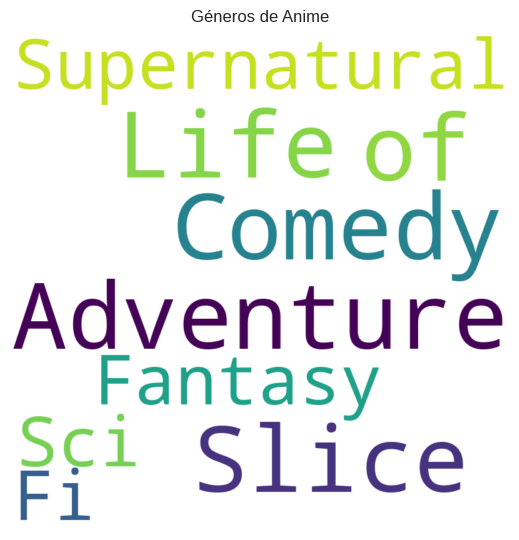

In [232]:
genres_list = get_genres_from_api()

anime_data = {
    'data': {
        'genres': [{'name': genre} for genre in genres_list]
    }
}

def create_genre_wordcloud(anime_data):
    if isinstance(anime_data, dict):
        try:
            # Extraigo los géneros
            genres_list = [genre['name'] for genre in anime_data['data']['genres']]

            # Creo un df a partir de la lista de géneros
            dfGenero = pd.DataFrame(genres_list, columns=['Genre'])

            # Creo una cadena de texto con todos los géneros
            genres = ' '.join(dfGenero['Genre'])

            # Creo la nube de palabras
            wordcloud = WordCloud(width=800, height=800,
                                  background_color='white',
                                  stopwords=set(),
                                  min_font_size=10).generate(genres)

            # visualizo la nube de palabras
            plt.figure(figsize=(5, 5), facecolor=None)
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.tight_layout(pad=0)

            # agrego el título
            plt.title("Géneros de Anime")

            plt.show()

        except KeyError as e:
            print(f"Falta una clave en el diccionario de datos: {e}")
        except Exception as e:
            print(f"Se produjo un error: {e}")
    else:
        print("Los datos recibidos no son un diccionario")

# llamo a la función para generar la nube de palabras
create_genre_wordcloud(anime_data)

**Y una de las preguntas más debatidas, ¿cuáles son los MEJORES animes de todos los tiempos?**

In [233]:
def get_top_animes_from_api(page=1):
    url = f"https://api.jikan.moe/v4/anime?order_by=score&sort=desc&page={page}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        top_animes = [{'title': anime['title'],
                       'score': anime['score'],
                       'images.jpg.image_url': anime['images']['jpg']['image_url']}
                      for anime in data.get('data', [])]

        return top_animes
    else:
        return []

In [234]:
# df top_animes
top_animes = get_top_animes_from_api()
df = pd.DataFrame(top_animes)

# ordeno por score de manera descendente
df = df.sort_values(by='score', ascending=False)

df = df.head(10)  # tomo los primeros 10 animes

# cambio el índice para que comience en 1
df.index = range(1, len(df) + 1)

# función para mostrar imágenes en el df
def path_to_image_html(path):
    return '<img src="' + path + '" width="150" >'

# función para resaltar el título
def highlight_title(title):
    return f'<span style="font-size: 1.5em; font-weight: bold;">{title}</span>'

# creo el título del gráfico
title_html = """
<style>
    .title {
        font-size: 24px;
        font-weight: bold;
        text-align: left;
    }
</style>
<div class="title">Top 10 animes mejor puntuados de todos los tiempos</div>
"""

# muestro el título y el df sin encabezados de columnas e índice
display(HTML(title_html + df.to_html(escape=False, formatters={
    'images.jpg.image_url': path_to_image_html,
    'title': highlight_title
}, index=False, header=False)))


Fullmetal Alchemist: Brotherhood,9.10,
Steins;Gate,9.07,
Gintama°,9.06,
Sousou no Frieren,9.05,
Shingeki no Kyojin Season 3 Part 2,9.05,
Gintama: The Final,9.04,
Bleach: Sennen Kessen-hen,9.04,
Hunter x Hunter (2011),9.04,
Gintama',9.03,
Gintama': Enchousen,9.03,


# 8. Análisis Demográfico

Ahora, adentrandome más en lo específico de mi análisis e interés con este dataset, veamos algunos datos demográficos:

**Primero veamos como se distribuye el anime según las categorías de edad**

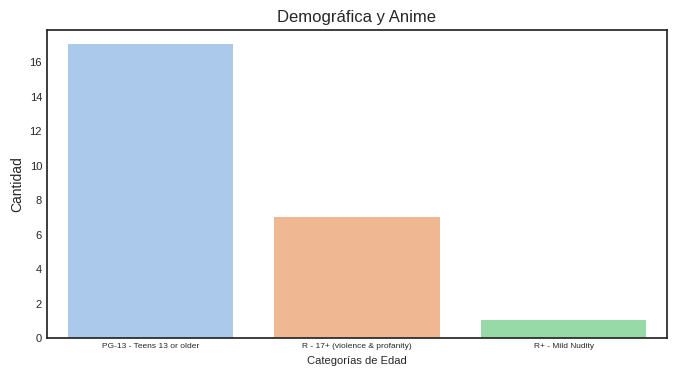

In [235]:
def get_anime_rating_from_api(page=1):
    url = f"https://api.jikan.moe/v4/top/anime"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        top_animes = [{'title': anime['title'],
                       'score': anime['score'],
                       'images.jpg.image_url': anime['images']['jpg']['image_url'],
                       'rating': anime['rating']}
                      for anime in data.get('data', [])]

        return top_animes
    else:
        return []

# llamo a la API para obtener datos de animes
animes = get_anime_rating_from_api()
df_anime = pd.DataFrame(animes)

# Configuración y visualización del gráfico
plt.figure(figsize=(8,4))
ax = sns.countplot(data = df_anime, x = df_anime["rating"], order = df_anime['rating'].value_counts().index.sort_values(), palette="pastel")
ax.set(title='Demográfica y Anime')
plt.xticks(fontsize=6)
plt.xlabel("Categorías de Edad", size = 8)
plt.yticks(size = 8)
plt.ylabel("Cantidad", size = 10)
plt.show()

Mayoritariamente para un público adolescente, con un considerable contenido Restringido +17 y luego un menor, pero igualmente significamente, R+ por mínima desnudez.

Tengamos en cuenta que no se está contando acá el contenido que es explicito para adultos.

**Vamos a observar ahora el df de usuarios de MAL**

Primero algunos datos básicos

In [236]:
#print(user_df.columns)

In [237]:
print(user_df['stats_mean_score'].describe())

count    116133.000000
mean          7.713389
std           1.538595
min           0.000000
25%           7.310000
50%           7.880000
75%           8.460000
max          10.000000
Name: stats_mean_score, dtype: float64


Demosle una mirada la distribución de las puntuaciones que los usuarios de MAL le dieron a los animes que vieron

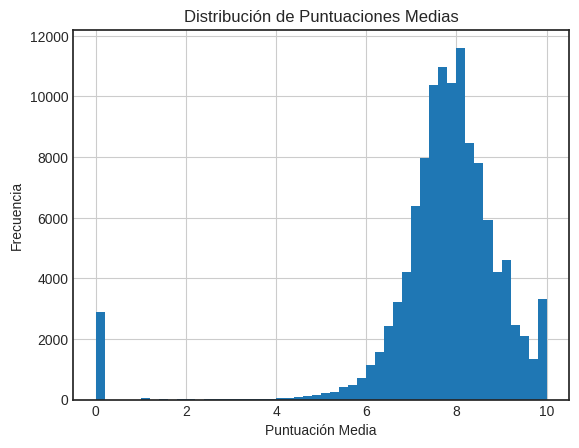

In [238]:
user_df['stats_mean_score'].hist(bins=50)
plt.title('Distribución de Puntuaciones Medias')
plt.xlabel('Puntuación Media')
plt.ylabel('Frecuencia')
plt.show()

Las puntuaciones se concentran significativamente entre el 7 a 8, lo que sugiere que la mayoría de los titulos han recibido puntuaciones dentro de este rango.
Hay muy pocas puntuaciones en los extremos bajos (cerca de 0) y altos (cerca de 10), lo que nos dice que existen pocos titulos con puntuaciones muy bajas o perfectas.
La forma de la distribución es ligeramente sesgada hacia la izquierda, lo que significa que hay una tendencia a que las puntuaciones sean más altas en lugar de más bajas.

**Boxplot** Para identificar posibles valores atípicos

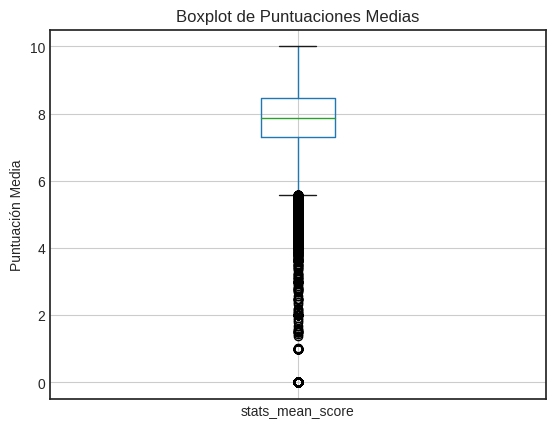

In [239]:
user_df.boxplot(column=['stats_mean_score'])
plt.title('Boxplot de Puntuaciones Medias')
plt.ylabel('Puntuación Media')
plt.show()

Este boxplot confirma lo que las estadísticas descriptivas sugerían: aunque la mayoría de las puntuaciones están agrupadas alrededor de 7 a 8.5, hay una dispersión considerable y una cantidad significativa de valores atípicos bajos. Estos valores atípicos podrían estar afectando la media y podrían merecer una investigación más detallada para entender por qué algunos usuarios tienen puntuaciones medias tan bajas (entiendo que, es común en la web de MAL, no tener puntuaciones, la web lo permite. Esto afecta las medidas). Además, el hecho de que la caja no esté centrada perfectamente alrededor de la línea de la mediana indica que hay una ligera asimetría en los datos, con una cola de distribución hacia las puntuaciones más bajas.

**Scatter Plot** para comprobar la dispersión de puntuaciones medias con otra variable como 'user_days_spent_watching' (los días que el usuario pasó mirando anime)

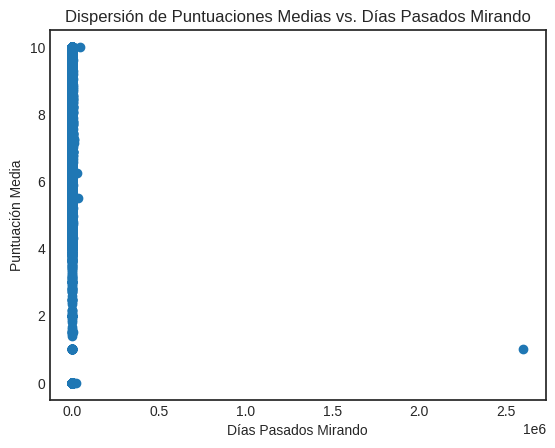

In [240]:
plt.scatter(user_df['user_days_spent_watching'], user_df['stats_mean_score'])
plt.title('Dispersión de Puntuaciones Medias vs. Días Pasados Mirando')
plt.xlabel('Días Pasados Mirando')
plt.ylabel('Puntuación Media')
plt.show()

El scatter plot muestra que no hay una correlación evidente entre el tiempo dedicado a mirar y las puntuaciones medias otorgadas por los usuarios. Además, algunos valores atípicos extremos indican comportamientos o datos inusuales.

Vamos a comprobar si hay datos faltantes o nulos que podrían afectar el análisis:

In [241]:
print(user_df['stats_mean_score'].isnull().sum())

0


No hay

**Observemos la Distribución de Género de los Usuarios de MAL**

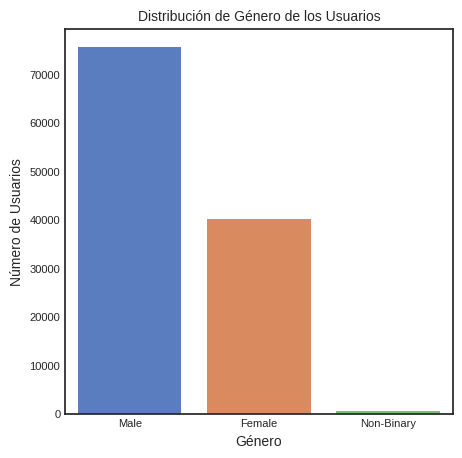

In [242]:
# Distribución de género
gender_distribution = user_df['gender'].value_counts()
plt.figure(figsize=(5, 5))
sns.barplot(x=gender_distribution.index, y=gender_distribution.values, palette='muted')
plt.title('Distribución de Género de los Usuarios', fontsize=10)
plt.xlabel('Género', fontsize=10)
plt.ylabel('Número de Usuarios', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

La mayoría de los usuarios son hombres y la mitad de esta cantidad, son mujeres. Con una muy breve cantidad de usuarios no binarios. Son datos esperados, pero que con el tiempo van cambiando y en tendencia de aumento, para los generos femenino y otros.

**Veamos entonces la Distribución de Edad de los usuarios**

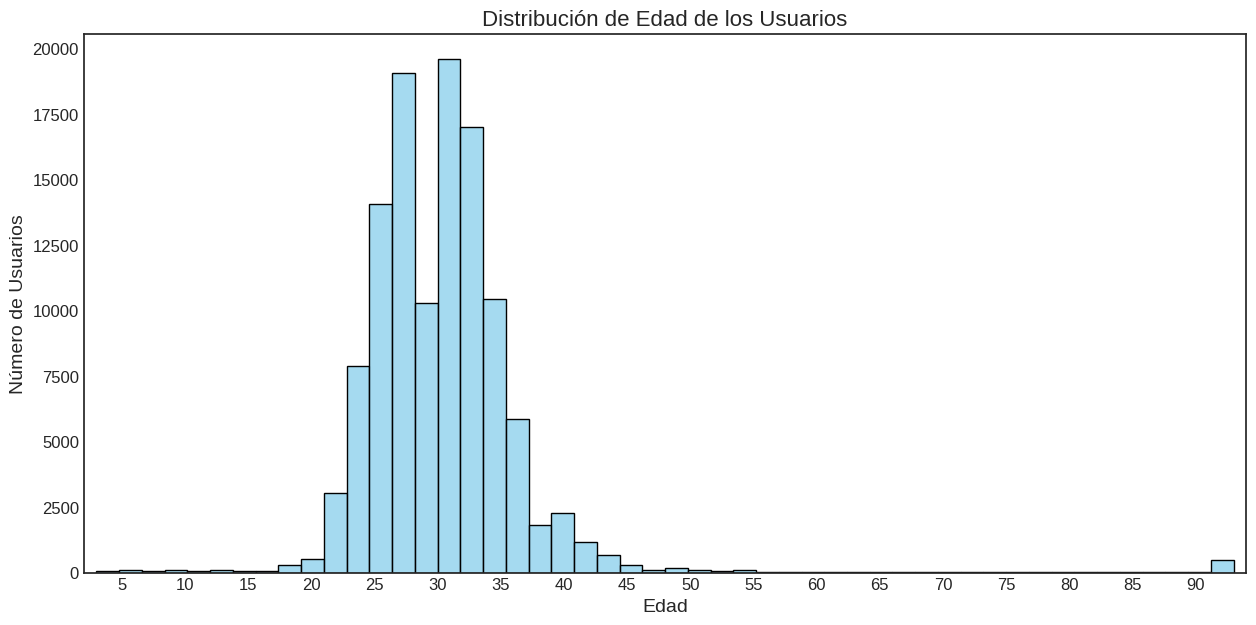

In [243]:
user_df['age'] = pd.to_numeric(user_df['age'], errors='coerce')
plt.figure(figsize=(15, 7))
sns.histplot(user_df['age'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de Edad de los Usuarios', fontsize=16)
plt.xlabel('Edad', fontsize=14)
plt.ylabel('Número de Usuarios', fontsize=14)
plt.xticks(range(0, 100, 5), fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([user_df['age'].min()-1, user_df['age'].max()+1])
plt.show()

Esto es normal para lo que ya hemos observado antes, el estereotípo del anime para infantes no es más que eso. Y las edades se distribuyen en una gran mayoría en jovenes adultos.

**¿Cómo es la tendencia de inscrimpciones por género a lo largo del tiempo para MAL?**

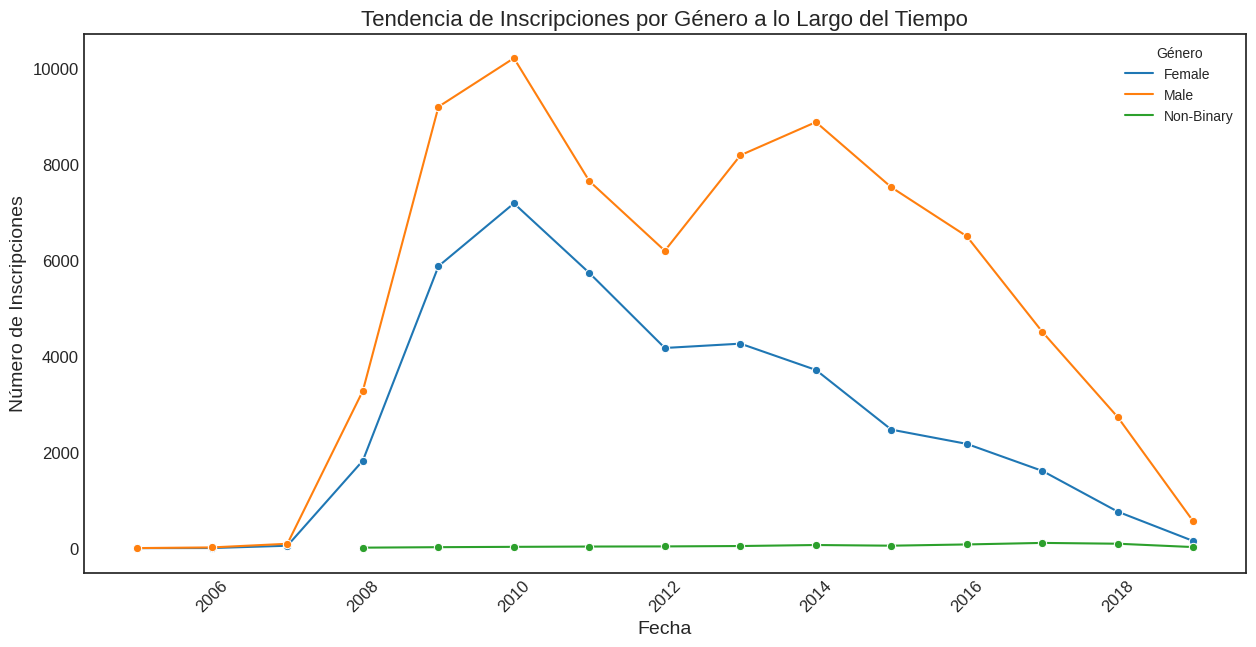

In [244]:
# me aseguro que la columna join_date este en formato fecha
user_df['join_date'] = pd.to_datetime(user_df['join_date'])

# la indico como 'join_date' como índice
user_df.set_index('join_date', inplace=True)

# agrupo por género y resampleo por año, contando las inscripciones
gender_time_series = user_df.groupby('gender').resample('A').size()

# reseteo el índice para facilitar la visualización
gender_time_series = gender_time_series.reset_index(name='count')

# visualizo la tendencia de inscripciones por género a lo largo del tiempo
plt.figure(figsize=(15, 7))
sns.lineplot(x='join_date', y='count', hue='gender', data=gender_time_series, marker='o')
plt.title('Tendencia de Inscripciones por Género a lo Largo del Tiempo', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Número de Inscripciones', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(title='Género')
plt.show()

Cómo mencionaba anteriormente, la tendencia ha ido en aumento para los generos mujer y no binario, aunque mínimamente para este último. Luego hay una decaida en las inscripciones hasta ahora, pero eso puede ser debido a una caída en la popularidad de la website o un cambio en la data que se registra, pudiendo ser un dato, género.

**Voy a realizar una prueba t para comparar media entre grupos**

In [245]:
# comparo el mean score de usuarios hombre y mujeres
score_male = user_df[user_df['gender'] == 'Male']['stats_mean_score']
score_female = user_df[user_df['gender'] == 'Female']['stats_mean_score']

# dropeo los valores NaN para evitar error durante el t-test
t_stat, p_val = ttest_ind(score_male.dropna(), score_female.dropna(), equal_var=False)

print(f"Estadistico t: {t_stat}, Valor p: {p_val}")


Estadistico t: -14.437751143962608, Valor p: 3.4742875388245588e-47


El resultado de la prueba t es bastante significativo. Aprox. -14 en Estadistico t y Valor p 3.4742875388245588e-47 sugiere que hay una marcada diferencia estadística entre las puntuaciones medias de los dos grupos que analicé: hombres y mujeres.


 Dado que el valor p es extremadamente pequeño, mucho menor que el umbral típico de 0,05 o umbrales incluso más estrictos, se puede rechazar la hipótesis nula de que los dos grupos tengan la misma puntuación media con alta confianza.  El signo negativo del estadístico t indica que la puntuación media del primer grupo que pasó (usuarios hombres) es menor que la puntuación media del segundo grupo (mujeres).